# 作业一：手写MLP，实战Kaggle比赛——预测房价

Kaggle的房价预测比赛数据集由Bart de Cock于2011年收集，
涵盖了2006-2010年期间亚利桑那州埃姆斯市的房价。
这个数据集是相当通用的，不会需要使用复杂模型架构。
它比哈里森和鲁宾菲尔德的波士顿房价 [https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names) 
数据集要大得多，也有更多的特征。

本次作业中，采用了多层感知机（MLP）模型，在Kaggle数据集上完成了房价预测的目标。主体过程如下：
- 下载数据：通过`setup`函数，搭建文件夹结构，下载数据集，为模型的训练做必要的准备。
- 数据的预处理、加载：通过数据预处理类`DataManager`、数据集类`Dataset`、数据加载器`DataLoader`和交叉验证数据的迭代生成器`CrossValidationDataLoader`，实现数据的预处理与加载过程。
- 网络层：通过神经网络基类`BaseModule`、神经网络模块序列`Sequential`、神经网络层基类`Layer`及派生类`Linear`、`ReLU`和`Dropout`，构造多层感知机模型。
- 损失函数：通过均方差损失函数类`MSELoss`、相对误差损失函数类`RelativeLoss`、对数均方差损失函数类`LMSELoss`评估模型结果，并比较分析各个损失函数的特点。
- 优化器：通过优化器基类`Optimizer`和派生类`Adam`优化器（包含L2权值衰减）和随机梯度下降`SGD`优化器（包含动量`momentum`和L2权值衰减`weight_decay`），实现参数的更新。
- 训练：通过神经网络训练工具类`Trainer`，实现模型训练、测试、k折交叉验证和结果的可视化。
- 验证：由于数据集较小，通过$k$折交叉验证方法对结果进行评估，选取最优的超参数。
- 测试：选取最优的超参数用于模型的测试，并计算其相对误差损失函数`RelativeLoss`和对数均方差损失函数`LMSELoss`。

上述功能均为**手写**完成，得到最终结果如下：
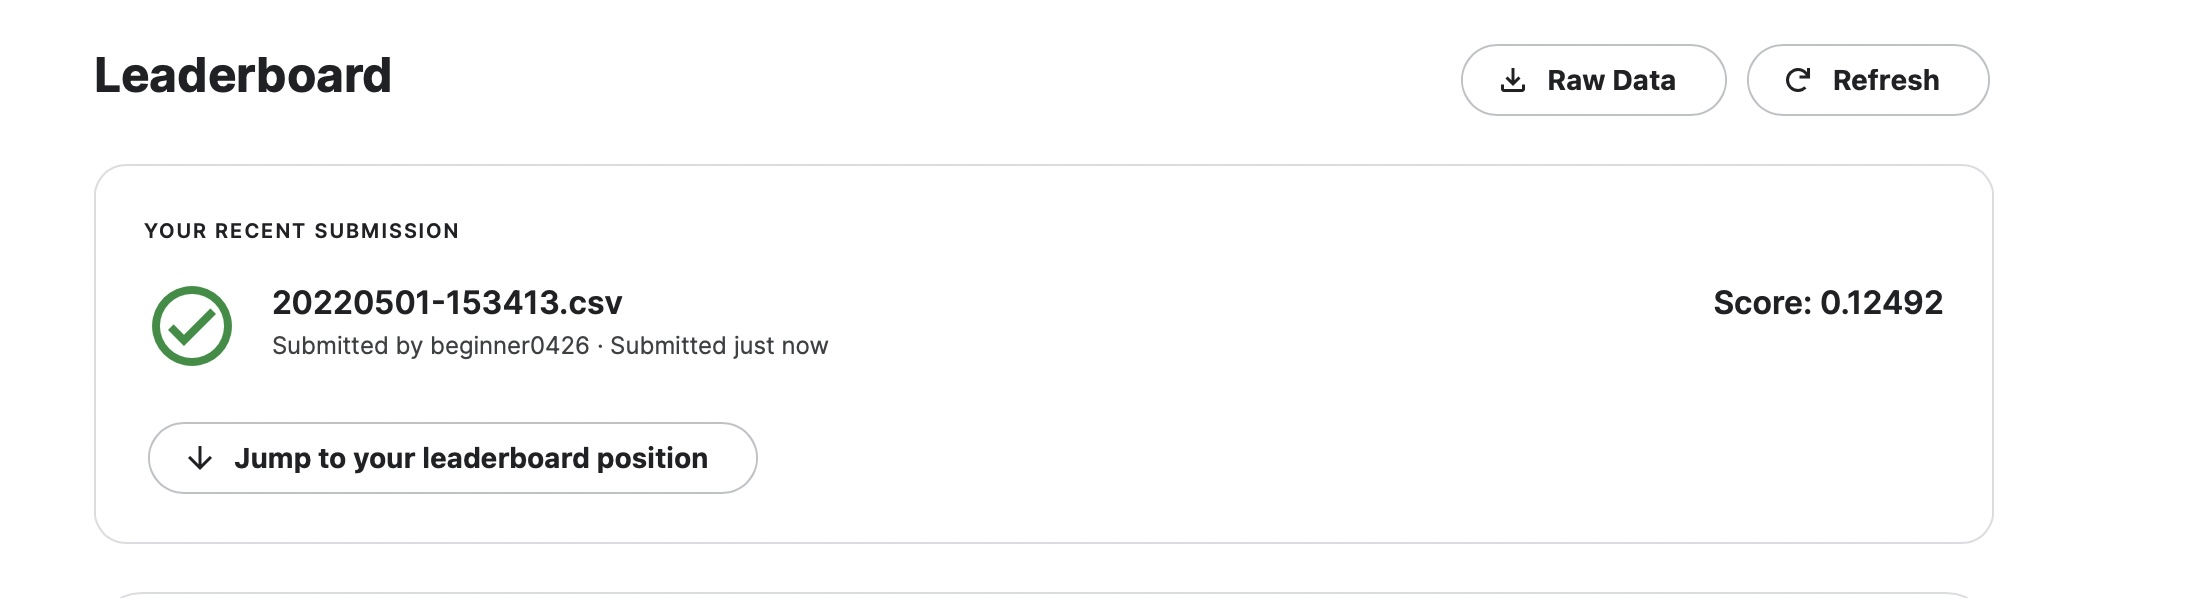

## 导入相关包

In [1]:
import os
import csv
import wget
import time
import math
import torch
import random
import datetime
import numpy as np
import pandas as pd
import torch.nn as nn
from matplotlib import pyplot as plt

## 文件夹结构搭建 & 下载数据集
构建文件夹，下载数据集，为模型的训练做必要的准备。完成后，文件夹结构如下：

```
├──Result（存储预测结果）  
├──Data（存储训练集、测试集）
    
```

In [2]:
def setup():
    folders = ['./Result', './Data']

    for folder in folders:
        if not os.path.exists(folder):
            os.mkdir(folder)
    
    print('Downloading training data:')
    wget.download('http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv', './Data/train.csv')
    print('\nDownloading testing data:')
    wget.download('http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv', './Data/test.csv')

setup()

100% [............................................................................] 460676 / 460676
100% [............................................................................] 451405 / 451405

# 训练

## 0.模型配置类：Config
包括模型各项必要的配置，用于存储学习率、SGD优化器动量值等超参数，并记录数据集位置、代码运行时间等。

In [3]:
class Config:
    def __init__(self):
        self.start_time = time.time()  # 记录程序开始时间

        self.epoch_num = 200           # 训练的轮次数量
        self.batch_size = 256          # 一个批次数据包含的样本数
        self.fold_num = 10             # k折交叉验证的折数
        self.lr = 1e-7                 # 优化器学习率
        self.momentum = 0.9            # SGD优化器动量值
        self.weight_decay = 100        # L2权值衰减系数
        self.dropout = 0.0             # 丢弃率
        self.feature_num = None        # 每条住房信息特征向量的特征数
        self.hidden_size = 1024        # 隐藏层特征数

        self.device = torch.device('cpu')
        self.result_root = './Result/'
        self.train_data_path = './Data/train.csv'
        self.test_data_path = './Data/test.csv'

## 1.数据预处理工具类

### 1.1 数据预处理类：DataManager
对数据进行预处理，完成以下操作：
- 进行数据清洗，对于分布离群的数据进行删除处理。
- 对于数值型数据，进行规范化处理。其中，对于空值数据，进行置零处理。
- 对于非数值型数据，生成one-hot向量。

In [4]:
class DataManager:
    def __init__(self, config):
        train_data = pd.read_csv(open(config.train_data_path))
        test_data = pd.read_csv(open(config.test_data_path))

        # 数据清洗，对于分布离群的数据进行删除处理
        train_data = train_data.drop(
            train_data[(train_data['OverallQual'] < 5) & (train_data['SalePrice'] > 200000)].index)
        train_data = train_data.drop(
            train_data[(train_data['GrLivArea'] > 4000) & (train_data['SalePrice'] < 300000)].index)
        train_data = train_data.drop(
            train_data[(train_data['YearBuilt'] < 1900) & (train_data['SalePrice'] > 400000)].index)
        train_data = train_data.drop(
            train_data[(train_data['TotalBsmtSF'] > 6000) & (train_data['SalePrice'] < 200000)].index)

        all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

        numerical_features = all_features.dtypes[all_features.dtypes != 'object'].index

        # 对于数值型数据，进行规范化处理
        all_features[numerical_features] = all_features[numerical_features].apply(
            lambda x: (x - x.mean()) / (x.std()))
        
        # 对于数值型数据中的空值，做置零处理
        all_features[numerical_features] = all_features[numerical_features].fillna(0)
        
        # 对于非数值型数据，生成one-hot向量
        all_features = pd.get_dummies(all_features, dummy_na=True) 

        n_train = train_data.shape[0]

        self.train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
        self.test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float)
        self.train_price = torch.tensor(train_data.SalePrice.values, dtype=torch.float).view(-1, 1)
        self.test_price = torch.zeros(self.test_features.size()[0], dtype=torch.float)

        config.feature_num = self.train_features.size()[1]

### 1.2 数据集：Dataset
继承DataSet类，划分了训练集、测试集，实现了数据读取流程的自定义。

In [5]:
class Dataset:
    def __init__(self, feature, price, fold_num=None, fold_no=None, mode=None):
        if not fold_num:
            self.feature = feature
            self.price = price
        else:
            fold_size = math.ceil(len(price) / fold_num)
            if mode == 'train' or mode == 'Train':
                index_list = list(range(fold_no * fold_size))
                if fold_no != fold_num - 1:
                    index_list.extend(list(range((fold_no + 1) * fold_size, len(price))))
                index_list = np.array(index_list)
                self.feature = feature[index_list]
                self.price = price[index_list]
            elif mode == 'test' or mode == 'Test':
                if fold_no != fold_num - 1:
                    index_list = list(range(fold_no * fold_size, (fold_no + 1) * fold_size))
                else:
                    index_list = list(range(fold_no * fold_size, len(price)))
                index_list = np.array(index_list)
                self.feature = feature[index_list]
                self.price = price[index_list]

    def __len__(self):
        return len(self.price)

    def __getitem__(self, idx_list):
        return self.feature[idx_list], self.price[idx_list]

### 1.3 数据加载器：DataLoader
手写实现了数据的加载过程，用于模型的训练和测试的迭代。

In [6]:
class DataLoader:
    def __init__(self, dataset, batch_size, shuffle):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.sequence = None
        self.index = 0
        self.init_sequence()

    def init_sequence(self):
        self.sequence = list(range(len(self.dataset)))
        if self.shuffle:
            random.shuffle(self.sequence)

    def __iter__(self):
        return self

    def __len__(self):
        return math.ceil(len(self.dataset) / self.batch_size)

    def __next__(self):
        if self.index == len(self):
            self.index = 0
            self.init_sequence()
            raise StopIteration
        else:
            if self.index != len(self) - 1:
                batch_index = self.sequence[self.index * self.batch_size: (self.index + 1) * self.batch_size]
            else:
                batch_index = self.sequence[self.index * self.batch_size:]
            self.index += 1
            return self.dataset.__getitem__(batch_index)

### 1.4 交叉验证数据的迭代生成器：CrossValidationDataLoader
完成了数据的加载，用于交叉验证数据的迭代。

In [7]:
class CrossValidateDataLoader:
    def __init__(self, dataset, batch_size, fold_num):
        self.dataset = dataset
        self.batch_size = batch_size
        self.fold_num = fold_num
        self.fold_size = math.ceil(len(self.dataset) / self.fold_num)
        self.index = 0

    def __len__(self):
        return self.fold_num

    def __iter__(self):
        return self

    def __next__(self):
        if self.index == self.fold_num:
            self.index = 0
            raise StopIteration
        else:
            train_dataset = Dataset(feature=self.dataset.feature, price=self.dataset.price, fold_num=self.fold_num, fold_no=self.index, mode='train')
            train_dataloader = DataLoader(dataset=train_dataset, batch_size=self.batch_size, shuffle=True)
            test_dataset = Dataset(feature=self.dataset.feature, price=self.dataset.price, fold_num=self.fold_num, fold_no=self.index, mode='test')
            test_dataloader = DataLoader(dataset=test_dataset, batch_size=self.batch_size, shuffle=False)
            self.index += 1
            return train_dataloader, test_dataloader

## 2.神经网络组成模块

### 2.1 神经网络基类：BaseModule
手写实现了神经网络基类`BaseModule`，是所有模型的模版类。

In [8]:
class BaseModule:
    def __init__(self, config=None):
        self._parameters = None  # 网络模块中所有张量组成的字典
        self.loss = None
        self.optimizer = None

        # 若传入config（顶层网络），则获取网络所处的设备和预训练信息
        if config is not None:
            self.device = config.device
        else:
            self.device = None

    # 网络模块的前向传播
    def forward(self, data) -> torch.Tensor:
        raise NotImplementedError

    # 获取当前网络及其所有子网络的参数字典
    def get_parameters(self) -> dict:
        for key in self.__dict__:
            # 递归构造网络参数字典
            if isinstance(self.__dict__[key], BaseModule):
                sub_state_dict = self.__dict__[key].get_parameters()
                for sub_key in sub_state_dict:
                    new_key = key + '.' + sub_key
                    self._parameters[new_key] = sub_state_dict[sub_key]
        return self._parameters

    # 获取顶层网络包含的全部需要计算梯度的张量列表
    def parameters(self) -> list:
        # 初次调用时初始化网络参数
        if self._parameters is None:
            self.init_parameters()
            self.get_parameters()
        grad_params = []
        for key in self._parameters:
            if isinstance(self._parameters[key], torch.Tensor):
                if self._parameters[key].requires_grad is True:
                    grad_params.append(self._parameters[key])
        return grad_params

    # 递归初始化网络参数
    def init_parameters(self, device=None):
        if device is None:
            device = self.device
        self._parameters = {}
        for key in self.__dict__:
            if isinstance(self.__dict__[key], BaseModule):
                self.__dict__[key].init_parameters(device)

    # 递归将网络设置为评估模式
    def eval(self):
        for key in self.__dict__:
            if isinstance(self.__dict__[key], BaseModule):
                self.__dict__[key].eval()

    # 递归将网络设置为训练模式
    def train(self):
        for key in self.__dict__:
            if isinstance(self.__dict__[key], BaseModule):
                self.__dict__[key].train()

### 2.2 神经网络模块序列：Sequential
继承`BaseModule`，手写实现了神经网络模块序列`Sequential`类，用于存放搭建神经网络的模块。

In [9]:
class Sequential(BaseModule):
    # 传入一个网络模块列表对Sequential类进行初始化
    def __init__(self, *layers):
        super(Sequential, self).__init__()
        self._parameters = {}
        self.layers = []
        for layer in layers:
            self.layers.append(layer)

    # 将神经网络模块序列的前向传播写入__call__方法
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    # 函数重载，递归初始化网络参数
    def init_parameters(self, device=None):
        for layers in self.layers:
            layers.init_parameters(device)

    # 函数重载，获取当前网络及其所有子网络的参数字典
    def get_parameters(self):
        for i, layer in enumerate(self.layers):
            state_dict = layer.get_parameters()
            for key in state_dict:
                # Sequential实例中的层从前到后以数字顺序命名，从0开始
                new_key = str(i) + '.' + key
                self._parameters[new_key] = state_dict[key]
        return self._parameters

    # 函数重载，递归将网络设置为评估模式
    def eval(self):
        for layer in self.layers:
            if isinstance(layer, BaseModule):
                layer.eval()

    # 函数重载，递归将网络设置为训练模式
    def train(self):
        for layer in self.layers:
            if isinstance(layer, BaseModule):
                layer.train()

### 2.3 神经网络层的实现
继承`BaseModule`类，实现神经网络层基类`Layer`，派生线性层`Linear`、激活函数`ReLU`和正则化层`Dropout`。

In [10]:
# 网络层基类，定义通用的接口
class Layer(BaseModule):
    def __init__(self):
        super(Layer, self).__init__()
        self._parameters = {}
        self.mode = 'Train'
        self.device = None

    def __call__(self, x) -> torch.Tensor:
        raise NotImplementedError

    def forward(self, data) -> torch.Tensor:
        return self.__call__(data)

    # 根据权重矩阵的尺寸计算扇入扇出，据此初始化权重矩阵和偏置矩阵，参考了pytorch官方代码的实现
    @staticmethod
    def _calculate_fan_in_and_fan_out(tensor):
        num_input = tensor.size(1)
        num_output = tensor.size(0)
        receptive_field_size = 1
        if tensor.dim() > 2:
            for s in tensor.shape[2:]:
                receptive_field_size *= s
        fan_in = num_input * receptive_field_size
        fan_out = num_output * receptive_field_size
        return fan_in, fan_out

    def init_parameters(self, device=None):
        self.device = device

    def get_parameters(self):
        return self._parameters

    def eval(self):
        self.mode = 'Eval'

    def train(self):
        self.mode = 'Train'


class ReLU(Layer):
    def __init__(self):
        super(ReLU, self).__init__()

    def __call__(self, x):
        return torch.where(x < 0.0, torch.tensor([0.0], device=self.device), x)


class Dropout(Layer):
    def __init__(self, dropout_ratio=0.5):
        super(Dropout, self).__init__()
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def __call__(self, x):
        # 训练模式下随机丢弃一定比例的信息，测试模式下保证数学期望不变
        if self.mode == 'Train':
            self.mask = torch.rand_like(x).to(self.device) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)


class Linear(Layer):
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias
        self.W = None
        self.B = None

    def __call__(self, x):
        if self.B is not None:
            return torch.matmul(x, self.W.T) + self.B
        else:
            return torch.matmul(x, self.W.T)

    def init_parameters(self, device=None):
        self.device = device
        self.W = torch.empty(self.out_features, self.in_features, device=self.device, requires_grad=True)
        nn.init.kaiming_uniform_(self.W, a=math.sqrt(5))
        self._parameters['weight'] = self.W
        if self.bias is True:
            self.B = torch.empty(self.out_features, device=self.device, requires_grad=True)
            fan_in, _ = self._calculate_fan_in_and_fan_out(self.W)
            if fan_in != 0:
                bound = 1 / math.sqrt(fan_in)
                nn.init.uniform_(self.B, -bound, bound)
                self._parameters['bias'] = self.B

### 2.4 损失函数

为评估模型预测结果、进行网络的反向传播，在此引入均方差损失函数`MSELoss`、相对误差损失函数`RelativeLoss`、对数均方差损失函数`LMSELoss`。实验结果表明：
- 均方差损失函数`MSELoss`：$\operatorname{loss}\left(\mathbf{x}_{i}, \mathbf{y}_{i}\right)=\left(\mathbf{x}_{i}-\mathbf{y}_{i}\right)^{2}$，进行反向传播求梯度时，模型的训练效果最佳；
- 相对误差损失函数`RelativeLoss`：$\operatorname{loss}\left(\mathbf{x}_{i}, \mathbf{y}_{i}\right)=\left|\dfrac{\mathbf{x}_{i}-\mathbf{y}_{i}}{\mathbf{y}_{i}}\right|$,能够直观地体现出模型预测结果的优劣程度，且结果与房价本身的大小无关；
- 对数均方差损失函数`LMSELoss`：$\operatorname{loss}\left( \mathbf{x}_{i}, \mathbf{y}_{i}\right)=\left(\log \mathbf{x}_{i}-\log \mathbf{y}_{i}\right)^{2}$，能够将房价转化成近似正态分布后再计算损失。

In [11]:
class MSELoss:
    def __call__(self, pred, gt):
        loss = pred - gt
        loss = loss * loss
        loss = torch.mean(loss)
        return loss


class RelativeLoss:
    def __call__(self, pred, gt):
        loss = (pred - gt) / gt
        loss = torch.abs(loss)
        loss = torch.mean(loss)
        return loss


class LMSELoss:
    def __call__(self, pred, gt):
        loss = torch.log(pred) - torch.log(gt)
        loss = loss * loss
        loss = torch.mean(loss)
        return loss

### 2.5 优化器
手写实现优化器基类`Optimizer`，自适应矩估计`Adam`优化器（包含L2权值衰减）和随机梯度下降`SGD`优化器（包含动量`momentum`和L2权值衰减`weight_decay`）。

In [12]:
class Optimizer:
    def __init__(self):
        self.params = None
        self.lr = None

    # 优化器更新参数的函数
    @torch.no_grad()
    def step(self):
        raise NotImplementedError

    # 优化器参数梯度归零的函数
    @torch.no_grad()
    def zero_grad(self):
        for param in self.params:
            if param.grad.grad_fn is not None:
                param.grad.detach_()
            else:
                param.grad.requires_grad_(False)
            param.grad.zero_()


# Adam优化器，参考了pytorch官方的实现
class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        super(Adam, self).__init__()
        self.params = params
        self.lr = lr
        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay
        self.iter = 0
        self.m = None
        self.v = None
        self.state = {}
        for param in self.params:
            self.state[param] = {}

    @torch.no_grad()
    def step(self):
        grads = []
        exp_avgs = []
        exp_avg_sqs = []
        state_steps = []
        beta1, beta2 = self.betas

        for param in self.params:
            grads.append(param.grad)

            state = self.state[param]
            if len(state) == 0:
                state['step'] = 0
                state['exp_avg'] = torch.zeros_like(param, memory_format=torch.preserve_format)
                state['exp_avg_sq'] = torch.zeros_like(param, memory_format=torch.preserve_format)

            exp_avgs.append(state['exp_avg'])
            exp_avg_sqs.append(state['exp_avg_sq'])

            state['step'] += 1
            state_steps.append(state['step'])

        for i, param in enumerate(self.params):
            grad = grads[i]
            exp_avg = exp_avgs[i]
            exp_avg_sq = exp_avg_sqs[i]
            step = state_steps[i]

            bias_correction1 = 1 - beta1 ** step
            bias_correction2 = 1 - beta2 ** step

            if self.weight_decay != 0:
                grad = grad.add(param, alpha=self.weight_decay)

            exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
            exp_avg_sq.mul_(beta2).addcmul_(grad, grad.conj(), value=1 - beta2)
            denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(self.eps)

            step_size = self.lr / bias_correction1
            param.addcdiv_(exp_avg, denom, value=-step_size)


# SGD优化器，参考了pytorch官方的实现
class SGD(Optimizer):
    def __init__(self, params, lr, momentum=0, weight_decay=0):
        super(SGD, self).__init__()
        self.params = params
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.state = {}
        for param in self.params:
            self.state[param] = {}

    @torch.no_grad()
    def step(self):
        grads = []
        momentum_buffer_list = []
        weight_decay = self.weight_decay
        momentum = self.momentum
        lr = self.lr

        for param in self.params:
            grads.append(param.grad)

            state = self.state[param]
            if 'momentum_buffer' not in state:
                momentum_buffer_list.append(None)
            else:
                momentum_buffer_list.append(state['momentum_buffer'])

        for i, param in enumerate(self.params):
            grad = grads[i]
            if weight_decay != 0:
                grad = grad.add(param, alpha=weight_decay)

            if momentum != 0:
                buf = momentum_buffer_list[i]
                if buf is None:
                    buf = torch.clone(grad).detach()
                    momentum_buffer_list[i] = buf
                else:
                    buf.mul_(momentum).add_(grad, alpha=1)
                grad = buf

            alpha = -lr
            param.add_(grad, alpha=alpha)

        for param, momentum_buffer in zip(self.params, momentum_buffer_list):
            state = self.state[param]
            state['momentum_buffer'] = momentum_buffer

## 3.网络模型：Model
模型的主体部分采用了多层感知机模型，首先在训练模式下通过`dropout`随机丢弃一定比例的信息，再将特征通过线性层、ReLU激活函数和线性层输出。同时，该函数实现了一个batch的训练、测试过程和计算并返回房价预测值等功能。

In [13]:
class Model(BaseModule):
    def __init__(self, config):
        super(Model, self).__init__()
        self.is_training = True
        self.config = config
        self.dropout = Dropout(config.dropout)
        self.fc = Sequential(
            Dropout(config.dropout),
            Linear(in_features=config.feature_num, out_features=config.hidden_size),
            ReLU(),
            Linear(in_features=config.hidden_size, out_features=1)
        )
        self.loss = MSELoss()
        self.loss_a = RelativeLoss()
        self.loss_b = LMSELoss()
        self.optimizer = SGD(
            params=self.parameters(),
            lr=self.config.lr,
            momentum=self.config.momentum,
            weight_decay=self.config.weight_decay
        )

    def forward(self, data):
        x = self.fc(data)
        return x

    # 顶层网络一个batch的训练过程，返回该batch的loss之和
    def step(self, data):
        pred = self.forward(data[0])
        loss = self.loss(pred, data[1])
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

    # 一个batch的测试过程，返回RelativeLoss值和LMSELoss值
    @torch.no_grad()
    def evaluate(self, data):
        pred = self.forward(data[0])
        loss_a = self.loss_a(pred, data[1])
        loss_b = self.loss_b(pred, data[1])
        return loss_a.tolist(), loss_b.tolist(), len(pred)

    # 计算并返回房价预测值
    @torch.no_grad()
    def get_pred(self, data):
        pred = self.forward(data[0])
        pred = pred.reshape(pred.size()[0])
        return pred.tolist()

    # 重置网络参数，用于k折交叉验证
    def reset_parameters(self):
        self._parameters = None
        self.optimizer = SGD(
            params=self.parameters(),
            lr=self.config.lr,
            momentum=self.config.momentum,
            weight_decay=self.config.weight_decay
        )


## 4.神经网络训练工具类：Trainer
集成了模型训练、测试、k折交叉验证和结果可视化等功能。

In [14]:
class Trainer:
    def __init__(self, config, network, datamanager):
        self.start_time = config.start_time
        self.end_time = None

        self.network = network
        self.train_dataset = Dataset(feature=datamanager.train_features, price=datamanager.train_price)
        self.test_dataset = Dataset(feature=datamanager.test_features, price=datamanager.test_price)
        self.train_dataloader = DataLoader(dataset=self.train_dataset, batch_size=config.batch_size, shuffle=True)
        self.test_dataloader = DataLoader(dataset=self.test_dataset, batch_size=config.batch_size, shuffle=False)
        self.cross_validate_dataloader = CrossValidateDataLoader(
            dataset=self.train_dataset,
            batch_size=config.batch_size,
            fold_num=config.fold_num
        )
        self.config = config

    # 神经网络训练主函数
    def train(self):
        self.network.train()
        print('======================')
        print('Training result:')
        print('Epoch   TrRe/%  TrLMSE')
        dataloader = self.train_dataloader
        for i in range(self.config.epoch_num):
            for j, data in enumerate(dataloader):
                self.network.step(data)
            if (i + 1) % 10 == 0:
                self.network.eval()
                relative_loss = 0
                log_mse_loss = 0
                for j, data in enumerate(dataloader):
                    r, l, num = self.network.evaluate(data)
                    relative_loss += r * num
                    log_mse_loss += l * num
                relative_loss /= len(self.train_dataset)
                log_mse_loss /= len(self.train_dataset)
                info = '{:<8d}'.format(i + 1) + '{:<8.2f}'.format(relative_loss * 100) + '{:<8.4f}'.format(log_mse_loss)
                print(info)
                self.network.train()
        print('======================')

    # 神经网络测试主函数，包括测试集预测结果的保存
    def test(self):
        self.network.eval()
        dataloader = self.test_dataloader
        pred_list = []
        for i, data in enumerate(dataloader):
            pred = self.network.get_pred(data)
            pred_list.extend(pred)

        t = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
        filepath = self.config.result_root + t + '.csv'
        file = open(filepath, 'w', newline='')
        writer = csv.writer(file)
        writer.writerow(['Id', 'SalePrice'])
        for i in range(len(pred_list)):
            writer.writerow([i + 1461, pred_list[i]])

    # k折交叉验证主函数，包含结果可视化
    def cross_validate(self):
        self.network.train()
        print('======================================')
        print('Cross validation result:')
        dataloader = self.cross_validate_dataloader
        print('Fold    TrRe/%  TrLMSE  TeRe/%  TeLMSE')
        tr_re = 0
        tr_lmse = 0
        te_re = 0
        te_lmse = 0
        pred_list = []
        for i, (train_dataloader, test_dataloader) in enumerate(dataloader):
            self.network.reset_parameters()

            self.network.train()
            for j in range(self.config.epoch_num):
                for k, data in enumerate(train_dataloader):
                    self.network.step(data)

            self.network.eval()
            train_relative_loss = 0
            train_log_mse_loss = 0
            test_relative_loss = 0
            test_log_mse_loss = 0
            for k, data in enumerate(train_dataloader):
                tr_r, tr_l, num = self.network.evaluate(data)
                train_relative_loss += tr_r * num
                train_log_mse_loss += tr_l * num

            for k, data in enumerate(test_dataloader):
                te_r, te_l, num = self.network.evaluate(data)
                test_relative_loss += te_r * num
                test_log_mse_loss += te_l * num
                pred = self.network.get_pred(data)
                pred_list.extend(pred)

            train_relative_loss /= len(train_dataloader.dataset)
            train_log_mse_loss /= len(train_dataloader.dataset)
            test_relative_loss /= len(test_dataloader.dataset)
            test_log_mse_loss /= len(test_dataloader.dataset)

            tr_re += train_relative_loss
            tr_lmse += train_log_mse_loss
            te_re += test_relative_loss
            te_lmse += test_log_mse_loss

            info = '{:<8d}'.format(i + 1) + '{:<8.2f}'.format(train_relative_loss * 100) + '{:<8.4f}'.format(
                train_log_mse_loss) + '{:<8.2f}'.format(test_relative_loss * 100) + '{:<8.4f}'.format(test_log_mse_loss)
            print(info)
        tr_re /= self.config.fold_num
        tr_lmse /= self.config.fold_num
        te_re /= self.config.fold_num
        te_lmse /= self.config.fold_num
        info = 'Avg     ' + '{:<8.2f}'.format(tr_re * 100) + '{:<8.4f}'.format(tr_lmse) + '{:<8.2f}'.format(
            te_re * 100) + '{:<8.4f}'.format(te_lmse)
        print(info)
        self.visualize(pred_list, self.train_dataset.price.reshape(self.train_dataset.price.size()[0]).tolist())
        print('======================================')
        self.end_time = time.time()
        print('Time consumed: {:<.2f}'.format(self.end_time - self.start_time), 's')

    @staticmethod
    def visualize(pred, gt):
        x = np.linspace(0, 700000, 1000)
        y = np.array([t for t in x])
        plt.figure()
        plt.xlabel('Prediction')
        plt.ylabel('Ground Truth')
        plt.scatter(pred, gt, s=1)
        plt.plot(x, y, 'red')
        plt.show()

## 5.模型训练

### 5.1 交叉验证    
由于样本数据较少，为了更好地选择模型的超参数，采用交叉验证方法对结果进行评估。具体过程如下：
1. 将训练集分为$k$份，选取$(k-1)$份用于训练，$1$份用于验证，记录预测的结果。
2. 重复步骤1，直到每个$k-fold$都得到了验证。
3. 通过步骤1记录的结果，计算模型性能的均值。
4. 对于不同的超参数，重复步骤1到步骤4。
5. 选取使得结果最优的超参数
6. 在测试集上评估模型性能。

Cross validation result:
Fold    TrRe/%  TrLMSE  TeRe/%  TeLMSE
1       6.23    0.0080  8.82    0.0169  
2       6.30    0.0082  7.97    0.0107  
3       6.20    0.0081  7.46    0.0132  
4       6.96    0.0091  9.35    0.0194  
5       6.27    0.0077  9.74    0.0206  
6       6.22    0.0082  7.24    0.0107  
7       6.25    0.0081  8.50    0.0140  
8       6.28    0.0083  7.26    0.0091  
9       6.29    0.0086  6.97    0.0081  
10      5.97    0.0075  9.07    0.0161  
Avg     6.30    0.0082  8.24    0.0139  


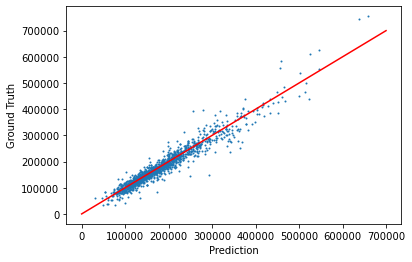

Time consumed: 51.61 s


In [15]:
config = Config()
datamanager = DataManager(config)
model = Model(config)
trainer = Trainer(config, model, datamanager)
trainer.cross_validate()

### 5.2 训练并保存测试集结果
将最优的超参数在测试集上评估，并计算对应的相对误差损失函数`RelativeLoss`和对数均方差损失函数`LMSELoss`。

In [16]:
config = Config()
datamanager = DataManager(config)
model = Model(config)
trainer = Trainer(config, model, datamanager)
trainer.train()
trainer.test()

Training result:
Epoch   TrRe/%  TrLMSE
10      13.86   0.1284  
20      9.81    0.0235  
30      9.31    0.0158  
40      8.55    0.0141  
50      8.28    0.0134  
60      7.88    0.0119  
70      7.50    0.0112  
80      7.33    0.0108  
90      7.15    0.0103  
100     7.12    0.0101  
110     6.98    0.0101  
120     6.93    0.0099  
130     6.82    0.0094  
140     6.63    0.0091  
150     6.56    0.0089  
160     6.54    0.0089  
170     6.74    0.0092  
180     6.33    0.0085  
190     6.26    0.0084  
200     6.23    0.0082  
